<a target="_blank" href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL-Tutorials/blob/master/2-Advance/FinRL_PortfolioAllocation_Explainable_DRL.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Explainable Deep Reinforcement Learning for Portfolio Managemnet: an Emprical Approach.

Tutorials to use FinRL Library to perform explainable portfolio allocation in one [Jupyter Notebook](https://colab.research.google.com/drive/117v2qWo-qPC7OPd7paY1wYkOUywU_DWZ?usp=sharing)

* This tutorial is based on the [portfolio allocation tutorial](https://github.com/AI4Finance-Foundation/FinRL/blob/master/FinRL_portfolio_allocation_NeurIPS_2020.ipynb) in FinRL Library.
* This blog is based on our paper: Explainable Deep Reinforcement Learning for Portfolio Managemnet: an Emprical Approach
* Please report any issues to our Github: https://github.com/AI4Finance-LLC/FinRL-Library/issues
* **Pytorch Version**



# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)             

<a id='0'></a>
# Part 1. Problem Definition

This problem is to empirically explain the trading performance of DRL agents for the portfolio management task.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed portfolio weights that the agent interacts with the
environment. Each element in the portfolio weights is between [0, 1].

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The logorithmic rate of portfolio return when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = ln(v'/v), where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes  an agent’s perception of a market.  Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents

We use Yahoo Finance API as the data source.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [13]:
# ## install finrl library
# !pip install plotly==4.4.1
# !wget https://github.com/plotly/orca/releases/download/v1.2.1/orca-1.2.1-x86_64.AppImage -O /usr/local/bin/orca
# !chmod +x /usr/local/bin/orca
# !apt-get install xvfb libgtk2.0-0 libgconf-2-4
# !pip install wrds
# !pip install swig
# !pip install -q condacolab
# import condacolab
# condacolab.install()
# !apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
# !pip install git+https://github.com/AI4Finance-Foundation/FinRL.git
# !pip install PyPortfolioOpt


<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them.
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [14]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
%matplotlib inline
import datetime

from finrl import config
from finrl import config_tickers
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_portfolio_allocation.env_portfolio import StockPortfolioEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline,convert_daily_return_to_pyfolio_ts
from finrl.meta.data_processor import DataProcessor
from finrl.meta.data_processors.processor_yahoofinance import YahooFinanceProcessor
import sys
sys.path.append("../FinRL-Library")

<a id='1.4'></a>
## 2.4. Create Folders

In [15]:
import os
from finrl import config
from finrl import config_tickers

if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).


In [16]:
tickers = ["^TNX", "XU030.IS"]
# tickers = ["XU030.IS"]

In [17]:
# import yfinance as yf
# start_date ='2000-01-01'
# end_date = '2023-09-20'
# data = yf.download(tickers, start=start_date, end=end_date)

In [18]:
# data.head()

In [19]:
# df = YahooDownloader(start_date = '2000-01-01',
#                            end_date = '2023-09-20',
#                            ticker_list = tickers).fetch_data()

In [20]:
df = pd.read_csv("/content/tickers.csv")

In [21]:
df['date'] = pd.to_datetime(df['date'])
df['date'] = df['date'].dt.strftime('%Y-%m-%d')
df = df.sort_values(['date','tic'],ignore_index=True)
# Filter the DataFrame to keep only rows where the date is common for all tickers
df = df[df.groupby('date')['tic'].transform('nunique') == len(tickers)]

# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [22]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    use_turbulence=False,
                    user_defined_feature = False)

df = fe.preprocess_data(df)

Successfully added technical indicators


## Add covariance matrix as states

In [23]:
# add covariance matrix as states
df=df.sort_values(['date','tic'],ignore_index=True)
df.index = df.date.factorize()[0]

cov_list = []
return_list = []

# look back is one year
lookback=252
for i in range(lookback,len(df.index.unique())):
  data_lookback = df.loc[i-lookback:i,:]
  price_lookback=data_lookback.pivot_table(index = 'date',columns = 'tic', values = 'close')
  return_lookback = price_lookback.pct_change().dropna()
  return_list.append(return_lookback)

  covs = return_lookback.cov().values
  cov_list.append(covs)


df_cov = pd.DataFrame({'date':df.date.unique()[lookback:],'cov_list':cov_list,'return_list':return_list})
df = df.merge(df_cov, on='date')
df = df.sort_values(['date','tic']).reset_index(drop=True)

<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed portfolio weights that the agent interacts with the environment. Each element in the portfolio weights vector is non-negative and no more than 100%. Also, the sum of elements in each portfolio weight should equal to 100%.

## Training data split: 2009-01-01 to 2020-06-30

In [24]:
train = data_split(df, '2000-01-01','2018-04-01')


## Environment for Portfolio Allocation


In [25]:
import numpy as np
import pandas as pd
from gym.utils import seeding
import gym
from gym import spaces
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from stable_baselines3.common.vec_env import DummyVecEnv


class StockPortfolioEnv(gym.Env):
    """A portfolio allocation environment for OpenAI gym

    Attributes
    ----------
        df: DataFrame
            input data
        stock_dim : int
            number of unique stocks
        hmax : int
            maximum number of shares to trade
        initial_amount : int
            start money
        transaction_cost_pct: float
            transaction cost percentage per trade
        reward_scaling: float
            scaling factor for reward, good for training
        state_space: int
            the dimension of input features
        action_space: int
            equals stock dimension
        tech_indicator_list: list
            a list of technical indicator names
        turbulence_threshold: int
            a threshold to control risk aversion
        day: int
            an increment number to control date

    Methods
    -------
    _sell_stock()
        perform sell action based on the sign of the action
    _buy_stock()
        perform buy action based on the sign of the action
    step()
        at each step the agent will return actions, then
        we will calculate the reward, and return the next observation.
    reset()
        reset the environment
    render()
        use render to return other functions
    save_asset_memory()
        return account value at each time step
    save_action_memory()
        return actions/positions at each time step


    """
    metadata = {'render.modes': ['human']}

    def __init__(self,
                df,
                stock_dim,
                hmax,
                initial_amount,
                transaction_cost_pct,
                reward_scaling,
                state_space,
                action_space,
                tech_indicator_list,
                turbulence_threshold=None,
                lookback=252,
                day = 0):
        #super(StockEnv, self).__init__()
        #money = 10 , scope = 1
        self.day = day
        self.lookback=lookback
        self.df = df
        self.stock_dim = stock_dim
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.transaction_cost_pct =transaction_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list

        # action_space normalization and shape is self.stock_dim
        self.action_space = spaces.Box(low = 0, high = 1,shape = (self.action_space,))
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape = (self.state_space+len(self.tech_indicator_list),self.state_space))

        # load data from a pandas dataframe
        self.data = self.df.loc[self.day,:]
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        self.terminal = False
        self.turbulence_threshold = turbulence_threshold
        # initalize state: inital portfolio return + individual stock return + individual weights
        self.portfolio_value = self.initial_amount

        # memorize portfolio value each step
        self.asset_memory = [self.initial_amount]
        # memorize portfolio return each step
        self.portfolio_return_memory = [0]
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.date_memory=[self.data.date.unique()[0]]


    def step(self, actions):
        self.terminal = self.day >= len(self.df.index.unique())-1

        if self.terminal:
            df = pd.DataFrame(self.portfolio_return_memory)
            df.columns = ['daily_return']
            plt.plot(df.daily_return.cumsum(),'r')
            plt.savefig('results/cumulative_reward.png')
            plt.close()

            plt.plot(self.portfolio_return_memory,'r')
            plt.savefig('results/rewards.png')
            plt.close()

            print("=================================")
            print("begin_total_asset:{}".format(self.asset_memory[0]))
            print("end_total_asset:{}".format(self.portfolio_value))

            df_daily_return = pd.DataFrame(self.portfolio_return_memory)
            df_daily_return.columns = ['daily_return']
            if df_daily_return['daily_return'].std() !=0:
              sharpe = (252**0.5)*df_daily_return['daily_return'].mean()/ \
                       df_daily_return['daily_return'].std()
              print("Sharpe: ",sharpe)
            print("=================================")

            return self.state, self.reward, self.terminal,{}

        else:
            weights = self.softmax_normalization(actions)
            self.actions_memory.append(weights)
            last_day_memory = self.data

            #load next state
            self.day += 1
            self.data = self.df.loc[self.day,:]
            self.covs = self.data['cov_list'].values[0]
            self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
            portfolio_return = sum(((self.data.close.values / last_day_memory.close.values)-1)*weights)
            log_portfolio_return = np.log(sum((self.data.close.values / last_day_memory.close.values)*weights))
            # update portfolio value
            new_portfolio_value = self.portfolio_value*(1+portfolio_return)
            self.portfolio_value = new_portfolio_value

            # save into memory
            self.portfolio_return_memory.append(portfolio_return)
            self.date_memory.append(self.data.date.unique()[0])
            self.asset_memory.append(new_portfolio_value)

            # the reward is the new portfolio value or end portfolo value
            self.reward = new_portfolio_value


        return self.state, self.reward, self.terminal, {}

    def reset(self):
        self.asset_memory = [self.initial_amount]
        self.day = 0
        self.data = self.df.loc[self.day,:]
        # load states
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        self.portfolio_value = self.initial_amount
        #self.cost = 0
        #self.trades = 0
        self.terminal = False
        self.portfolio_return_memory = [0]
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.date_memory=[self.data.date.unique()[0]]
        return self.state

    def render(self, mode='human'):
        return self.state

    def softmax_normalization(self, actions):
        numerator = np.exp(actions)
        denominator = np.sum(np.exp(actions))
        softmax_output = numerator/denominator
        return softmax_output


    def save_asset_memory(self):
        date_list = self.date_memory
        portfolio_return = self.portfolio_return_memory
        #print(len(date_list))
        #print(len(asset_list))
        df_account_value = pd.DataFrame({'date':date_list,'daily_return':portfolio_return})
        return df_account_value

    def save_action_memory(self):
        # date and close price length must match actions length
        date_list = self.date_memory
        df_date = pd.DataFrame(date_list)
        df_date.columns = ['date']

        action_list = self.actions_memory
        df_actions = pd.DataFrame(action_list)
        df_actions.columns = self.data.tic.values
        df_actions.index = df_date.date
        #df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
        return df_actions

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs

In [26]:
stock_dimension = len(train.tic.unique())
state_space = stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")
tech_indicator_list = ['macd', 'rsi_30', 'cci_30', 'dx_30']
feature_dimension = len(tech_indicator_list)
print(f"Feature Dimension: {feature_dimension}")

Stock Dimension: 2, State Space: 2
Feature Dimension: 4


In [27]:
train.head()

,Unnamed: 0,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,cov_list,return_list
0,525,2001-01-22,14504.299805,14620.900391,13992.900391,14110.500000,0,XU030.IS,260,341.470746,15154.710888,10723.518898,51.169720,124.276097,15.770246,12467.549967,14153.008301,"[[0.001562591220045976, -3.92435968182094e-05]...",tic XU030.IS ^TNX date ...
0,526,2001-01-22,5.172000,5.233000,5.172000,5.221000,0,^TNX,265,-0.050137,5.299270,4.876930,45.262048,10.406064,18.401984,5.179433,5.436333,"[[0.001562591220045976, -3.92435968182094e-05]...",tic XU030.IS ^TNX date ...
1,527,2001-01-23,14110.500000,14110.500000,13470.400391,13846.799805,0,XU030.IS,261,332.969260,15232.265793,10838.084011,50.260409,87.268167,6.394814,12600.846615,14103.358285,"[[0.001557292288070286, -3.7044574924766546e-0...",tic XU030.IS ^TNX date ...
1,528,2001-01-23,5.217000,5.279000,5.172000,5.274000,0,^TNX,266,-0.035650,5.316921,4.869079,47.104754,33.610920,22.623918,5.171467,5.430033,"[[0.001557292288070286, -3.7044574924766546e-0...",tic XU030.IS ^TNX date ...
2,529,2001-01-24,13846.799805,14452.500000,13608.900391,13877.299805,0,XU030.IS,262,324.947078,15272.316781,11021.103043,50.365943,91.691844,11.414324,12757.343262,14053.948275,"[[0.0015422700744588604, -3.862360111952201e-0...",tic XU030.IS ^TNX date ...


In [28]:
env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "transaction_cost_pct": 0,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": tech_indicator_list,
    "action_space": stock_dimension,
    "reward_scaling": 1e-1

}

e_train_gym = StockPortfolioEnv(df = train, **env_kwargs)

In [29]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


/usr/local/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* We use two DRL algorithms in FinRL library PPO andf A2C

### Model 1: **A2C**


In [30]:
agent = DRLAgent(env = env_train)

A2C_PARAMS = {"n_steps": 10, "ent_coef": 0.005, "learning_rate": 0.0004}
model_a2c = agent.get_model(model_name="a2c",model_kwargs = A2C_PARAMS)

{'n_steps': 10, 'ent_coef': 0.005, 'learning_rate': 0.0004}
Using cuda device


In [31]:
trained_a2c = agent.train_model(model=model_a2c, tb_log_name='a2c',
                                total_timesteps=40000)

-------------------------------------
| time/                 |           |
|    fps                | 192       |
|    iterations         | 100       |
|    time_elapsed       | 5         |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -2.84     |
|    explained_variance | 1.19e-07  |
|    learning_rate      | 0.0004    |
|    n_updates          | 99        |
|    policy_loss        | 2.61e+07  |
|    reward             | 1668282.5 |
|    std                | 1         |
|    value_loss         | 1.06e+14  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 256       |
|    iterations         | 200       |
|    time_elapsed       | 7         |
|    total_timesteps    | 2000      |
| train/                |           |
|    entropy_loss       | -2.84     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0004    |
|    n_updat

### Model 2: **PPO**


In [32]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.005,
    "learning_rate": 0.001,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

{'n_steps': 2048, 'ent_coef': 0.005, 'learning_rate': 0.001, 'batch_size': 128}
Using cuda device


In [33]:
trained_ppo = agent.train_model(model=model_ppo,
                             tb_log_name='ppo',
                             total_timesteps=40000)

----------------------------------
| time/              |           |
|    fps             | 375       |
|    iterations      | 1         |
|    time_elapsed    | 5         |
|    total_timesteps | 2048      |
| train/             |           |
|    reward          | 2801184.8 |
----------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 338          |
|    iterations           | 2            |
|    time_elapsed         | 12           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 5.820766e-09 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.84        |
|    explained_variance   | 1.79e-07     |
|    learning_rate        | 0.001        |
|    loss                 | 4.75e+14     |
|    n_updates            | 10           |
|    policy_gradient_loss | -6.47e-07   

## Back-Testing
Assume that we have $1,000,000 initial capital at 2020-01-01. We use the PPO, A2C, SVM, Linear Regression, Decision Tree, Random Foreset models to trade Dow jones 30 constituent stocks.


In [34]:
trade = data_split(df,'2018-04-01', '2023-01-01')
e_trade_gym = StockPortfolioEnv(df = trade, **env_kwargs)


In [35]:
import torch
%matplotlib inline
import plotly.express as px


In [36]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
import pandas as pd
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import objective_functions
unique_tic = trade.tic.unique()
unique_trade_date = trade.date.unique()

In [37]:
baseline_df = pd.read_csv("/content/baseline_data.csv")
baseline_df['date'] = pd.to_datetime(baseline_df['date'])
baseline_df['date'] = baseline_df['date'].dt.strftime('%Y-%m-%d')
baseline_df = baseline_df.sort_values(['date','tic'],ignore_index=True)
# Filter the DataFrame to keep only rows where the date is common for all tickers
baseline_df.head()

,date,open,high,low,close,volume,tic,day
0,2018-04-02,24076.599609,24123.800781,23344.519531,23644.189453,509820000,^DJI,0
1,2018-04-03,23698.330078,24044.349609,23664.330078,24033.359375,394130000,^DJI,1
2,2018-04-04,23654.150391,24308.960938,23523.160156,24264.300781,388540000,^DJI,2
3,2018-04-05,24313.910156,24622.259766,24313.910156,24505.220703,347790000,^DJI,3
4,2018-04-06,24373.599609,24434.400391,23738.199219,23932.759766,395990000,^DJI,4


In [38]:
import pyfolio
%matplotlib inline
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline,convert_daily_return_to_pyfolio_ts

# baseline_df = get_baseline(
#         ticker="^DJI",
#         start = '2018-04-01',
#         end =  '2023-01-01')

baseline_df_stats = backtest_stats(baseline_df, value_col_name = 'close')
baseline_returns = get_daily_return(baseline_df, value_col_name="close")

dji_cumpod =(baseline_returns+1).cumprod()-1

Annual return          0.073651
Cumulative returns     0.401919
Annual volatility      0.217929
Sharpe ratio           0.435969
Calmar ratio           0.198595
Stability              0.679414
Max drawdown          -0.370862
Omega ratio            1.091783
Sortino ratio          0.603538
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.899592
Daily value at risk   -0.027079
dtype: float64


In [39]:
from pyfolio import timeseries

df_daily_return_a2c, df_actions_a2c = DRLAgent.DRL_prediction(model=trained_a2c,
                        environment = e_trade_gym)
df_daily_return_ppo, df_actions_ppo = DRLAgent.DRL_prediction(model=trained_ppo,
                        environment = e_trade_gym)
time_ind = pd.Series(df_daily_return_a2c.date)
a2c_cumpod =(df_daily_return_a2c.daily_return+1).cumprod()-1
ppo_cumpod =(df_daily_return_ppo.daily_return+1).cumprod()-1
DRL_strat_a2c = convert_daily_return_to_pyfolio_ts(df_daily_return_a2c)
DRL_strat_ppo = convert_daily_return_to_pyfolio_ts(df_daily_return_ppo)

perf_func = timeseries.perf_stats
perf_stats_all_a2c = perf_func( returns=DRL_strat_a2c,
                              factor_returns=DRL_strat_a2c,
                                positions=None, transactions=None, turnover_denom="AGB")
perf_stats_all_ppo = perf_func( returns=DRL_strat_ppo,
                              factor_returns=DRL_strat_ppo,
                                positions=None, transactions=None, turnover_denom="AGB")

/usr/local/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning:

You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.



begin_total_asset:1000000
end_total_asset:1226255.8912372875
Sharpe:  0.39753770169987673
hit end!


/usr/local/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning:

You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.



begin_total_asset:1000000
end_total_asset:1610713.484674681
Sharpe:  0.4866039916650301
hit end!


In [40]:
def extract_weights(drl_actions_list):
  a2c_weight_df = {'date':[], 'weights':[]}
  for i in range(len(drl_actions_list)):
    date = drl_actions_list.index[i]
    tic_list = list(drl_actions_list.columns)
    weights_list = drl_actions_list.reset_index()[list(drl_actions_list.columns)].iloc[i].values
    weight_dict = {'tic':[], 'weight':[]}
    for j in range(len(tic_list)):
      weight_dict['tic'] += [tic_list[j]]
      weight_dict['weight'] += [weights_list[j]]

    a2c_weight_df['date'] += [date]
    a2c_weight_df['weights'] += [pd.DataFrame(weight_dict)]

  a2c_weights = pd.DataFrame(a2c_weight_df)
  return a2c_weights

a2c_weights = extract_weights(df_actions_a2c)
ppo_weights = extract_weights(df_actions_ppo)

## Machine Learning Models

We trained the machine learning models with technical indicators: MACD, RSI, CCI, DX

In [41]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

def prepare_data(trainData):
  train_date = sorted(set(trainData.date.values))
  X = []
  for i in range(0, len(train_date) - 1):
    d = train_date[i]
    d_next = train_date[i+1]
    y = train.loc[train['date'] == d_next].return_list.iloc[0].loc[d_next].reset_index()
    y.columns = ['tic', 'return']
    x = train.loc[train['date'] == d][['tic','macd','rsi_30','cci_30','dx_30']]
    train_piece = pd.merge(x, y, on = 'tic')
    train_piece['date'] = [d] * len(train_piece)
    X += [train_piece]
  trainDataML = pd.concat(X)
  X = trainDataML[tech_indicator_list].values
  Y = trainDataML[['return']].values

  return X, Y

train_X, train_Y = prepare_data(train)
rf_model = RandomForestRegressor(max_depth = 35,  min_samples_split = 10, random_state = 0).fit(train_X, train_Y.reshape(-1))
dt_model = DecisionTreeRegressor(random_state = 0, max_depth=35, min_samples_split = 10 ).fit(train_X, train_Y.reshape(-1))
svm_model =  SVR(epsilon=0.14).fit(train_X, train_Y.reshape(-1))
lr_model = LinearRegression().fit(train_X, train_Y)

In [42]:
def output_predict(model, reference_model = False):
  meta_coefficient = {"date":[], "weights":[]}

  portfolio = pd.DataFrame(index = range(1), columns = unique_trade_date)
  initial_capital = 1000000
  portfolio.loc[0,unique_trade_date[0]] = initial_capital

  for i in range(len(unique_trade_date) - 1):

      current_date = unique_trade_date[i]
      next_date = unique_trade_date[i+1]
      df_current = df[df.date==current_date].reset_index(drop=True)
      tics = df_current['tic'].values
      features = df_current[tech_indicator_list].values
      df_next = df[df.date==next_date].reset_index(drop=True)
      if not reference_model:
        predicted_y = model.predict(features)
        mu = predicted_y
        Sigma = risk_models.sample_cov(df_current.return_list[0], returns_data=True)
      else:
        mu = df_next.return_list[0].loc[next_date].values
        Sigma = risk_models.sample_cov(df_next.return_list[0], returns_data=True)
      predicted_y_df = pd.DataFrame({"tic":tics.reshape(-1,), "predicted_y":mu.reshape(-1,)})
      min_weight, max_weight = 0, 1
      ef = EfficientFrontier(mu, Sigma)
      weights = ef.nonconvex_objective(
          objective_functions.sharpe_ratio,
          objective_args=(ef.expected_returns, ef.cov_matrix),
          weights_sum_to_one=True,
          constraints=[
              {"type": "ineq", "fun": lambda w: w - min_weight},  # greater than min_weight
              {"type": "ineq", "fun": lambda w: max_weight - w},  # less than max_weight
          ],
      )

      weight_df = {"tic":[], "weight":[]}
      meta_coefficient["date"] += [current_date]
      # it = 0
      for item in weights:
        weight_df['tic'] += [item]
        weight_df['weight'] += [weights[item]]

      weight_df = pd.DataFrame(weight_df).merge(predicted_y_df, on = ['tic'])
      meta_coefficient["weights"] += [weight_df]
      cap = portfolio.iloc[0, i]
      #current cash invested for each stock
      current_cash = [element * cap for element in list(weights.values())]
      # current held shares
      current_shares = list(np.array(current_cash) / np.array(df_current.close))
      # next time period price
      next_price = np.array(df_next.close)
      portfolio.iloc[0, i+1] = np.dot(current_shares, next_price)

  portfolio=portfolio.T
  portfolio.columns = ['account_value']
  portfolio = portfolio.reset_index()
  portfolio.columns = ['date', 'account_value']
  stats = backtest_stats(portfolio, value_col_name = 'account_value')
  portfolio_cumprod =(portfolio.account_value.pct_change()+1).cumprod()-1

  return portfolio, stats, portfolio_cumprod, pd.DataFrame(meta_coefficient)

lr_portfolio, lr_stats, lr_cumprod, lr_weights = output_predict(lr_model)
dt_portfolio, dt_stats, dt_cumprod, dt_weights = output_predict(dt_model)
svm_portfolio, svm_stats, svm_cumprod, svm_weights = output_predict(svm_model)
rf_portfolio, rf_stats, rf_cumprod, rf_weights = output_predict(rf_model)
reference_portfolio, reference_stats, reference_cumprod, reference_weights = output_predict(None, True)

Annual return          0.215227
Cumulative returns     1.424678
Annual volatility      0.608533
Sharpe ratio           0.616729
Calmar ratio           0.289603
Stability              0.051402
Max drawdown          -0.743181
Omega ratio            1.145429
Sortino ratio          0.949389
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.048713
Daily value at risk   -0.075179
dtype: float64
Annual return          0.011718
Cumulative returns     0.054358
Annual volatility      0.523302
Sharpe ratio           0.278468
Calmar ratio           0.014643
Stability              0.217889
Max drawdown          -0.800204
Omega ratio            1.060985
Sortino ratio          0.412213
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.924094
Daily value at risk   -0.065352
dtype: float64
Annual return          0.564963
Cumulative returns     6.651703
Annual volatility      0.571583
Sharpe ratio           1.054919
Calmar rat

# Part 7: Explanation Method Implementation


### Integrated Gradient
>* Reference: [Integrated Gradients](https://www.tensorflow.org/tutorials/interpretability/integrated_gradients)

Implement the explanation method using integrated gradients and regression coefficients.
The formula for Integrated Gradients is as follows:

$IntegratedGradients_{i}(x) ::= (x_{i} - x'_{i})\times\int_{\alpha=0}^1\frac{\partial F(x'+\alpha \times (x - x'))}{\partial x_i}{d\alpha}$

where:

$_{i}$ = feature   
$x$ = input  
$x'$ = baseline   
$\alpha$ = interpolation constant to perturb features by


In practice, computing a definite integral is not always numerically possible and can be computationally costly, so you compute the following numerical approximation:

$IntegratedGrads^{approx}_{i}(x)::=(x_{i}-x'_{i})\times\sum_{k=1}^{m}\frac{\partial F(x' + \frac{k}{m}\times(x - x'))}{\partial x_{i}} \times \frac{1}{m}$

where:

$_{i}$ = feature (individual pixel)  
$x$ = input (image tensor)  
$x'$ = baseline (image tensor)  
$k$ = scaled feature perturbation constant  
$m$ = number of steps in the Riemann sum approximation of the integral  
$(x_{i}-x'_{i})$ = a term for the difference from the baseline. This is necessary to scale the integrated gradients and keep them in terms of the original image. The path from the baseline image to the input is in pixel space. Since with IG you are integrating in a straight line (linear transformation) this ends up being roughly equivalent to the integral term of the derivative of the interpolated image function with respect to $\alpha$ with enough steps. The integral sums each pixel's gradient times the change in the pixel along the path. It's simpler to implement this integration as uniform steps from one image to the other, substituting $x := (x' + \alpha(x-x'))$. So the change of variables gives $dx = (x-x')d\alpha$. The $(x-x')$ term is constant and is factored out of the integral.

In [43]:
def calculate_gradient(model, interpolated_input, actions,  feature_idx, stock_idx, h = 1e-1):
  forward_input = interpolated_input
  forward_input[feature_idx + stock_dimension][stock_idx] += h
  forward_Q = model.policy.evaluate_actions(torch.cuda.FloatTensor(forward_input).reshape(-1,stock_dimension*(stock_dimension + feature_dimension)), torch.cuda.FloatTensor(actions).reshape(-1,stock_dimension))
  interpolated_Q = model.policy.evaluate_actions(torch.cuda.FloatTensor(interpolated_input).reshape(-1,stock_dimension*(stock_dimension + feature_dimension)), torch.cuda.FloatTensor(actions).reshape(-1,stock_dimension))
  forward_Q = forward_Q[0].detach().cpu().numpy()[0]
  interpolated_Q = interpolated_Q[0].detach().cpu().numpy()[0]
  return (forward_Q - interpolated_Q) / h

In [44]:
import copy
meta_Q = {"date":[], "feature":[], "Saliency Map":[], "algo":[]}

for algo in {"A2C", "PPO"}:
  if algo == "A2C":
    prec_step = 1e-2
  else:
    prec_step = 1e-1

  model = eval("trained_" + algo.lower())
  df_actions = eval("df_actions_" + algo.lower())
  for i in range(len(unique_trade_date)-1):
    date = unique_trade_date[i]
    covs = trade[trade['date'] == date].cov_list.iloc[0]
    features = trade[trade['date'] == date][tech_indicator_list].values # N x K
    actions = df_actions.loc[date].values

    for feature_idx in range(len(tech_indicator_list)):

      int_grad_per_feature = 0
      for stock_idx in range(features.shape[0]):#N

        int_grad_per_stock = 0
        avg_interpolated_grad = 0
        for alpha in range(1, 51):
          scale = 1/50
          baseline_features = copy.deepcopy(features)
          baseline_noise = np.random.normal(0, 1, stock_dimension)
          baseline_features[:,feature_idx] = [0] * stock_dimension
          interpolated_features = baseline_features + scale * alpha * (features - baseline_features) # N x K
          interpolated_input = np.append(covs, interpolated_features.T, axis = 0)
          interpolated_gradient = calculate_gradient(model, interpolated_input, actions, feature_idx, stock_idx, h = prec_step)[0]

          avg_interpolated_grad += interpolated_gradient * scale
        int_grad_per_stock = (features[stock_idx][feature_idx] - 0) * avg_interpolated_grad
        int_grad_per_feature += int_grad_per_stock

      meta_Q['date'] += [date]
      meta_Q['algo'] += [algo]
      meta_Q['feature'] += [tech_indicator_list[feature_idx]]
      meta_Q['Saliency Map'] += [int_grad_per_feature]

meta_Q = pd.DataFrame(meta_Q)


### Regression Coefficient
Implement the linear regression to measure the feature weights.

In [45]:
# !pip install statsmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 52.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.8/233.8 kB 23.9 MB/s eta 0:00:00


In [46]:
import statsmodels.api as sm
meta_score_coef = {"date":[], "coef":[], "algo":[]}

for algo in ["LR", "RF", "Reference Model", "SVM", "DT", "A2C", "PPO"]:
  if algo == "LR":
    weights = lr_weights
  elif algo == "RF":
    weights = rf_weights
  elif algo == "DT":
    weights = dt_weights
  elif algo == "SVM":
    weights = svm_weights
  elif algo == "A2C":
    weights = a2c_weights
  elif algo == "PPO":
    weights = ppo_weights
  else:
    weights = reference_weights

  for i in range(len(unique_trade_date) - 1):
    date = unique_trade_date[i]
    next_date = unique_trade_date[i+1]
    df_temp = df[df.date==date].reset_index(drop=True)
    df_temp_next = df[df.date==next_date].reset_index(drop=True)
    weight_piece = weights[weights.date == date].iloc[0]['weights']
    piece_return = pd.DataFrame(df_temp_next.return_list.iloc[0].loc[next_date]).reset_index()
    piece_return.columns = ['tic', 'return']
    X = df_temp[['macd','rsi_30', 'cci_30', 'dx_30', 'tic']]
    X_next = df_temp_next[['macd','rsi_30', 'cci_30', 'dx_30', 'tic']]
    piece = weight_piece.merge(X, on = 'tic').merge(piece_return, on = 'tic')
    piece['Y'] = piece['return'] * piece['weight']
    X = piece[['macd','rsi_30', 'cci_30', 'dx_30']]
    X = sm.add_constant(X)
    Y = piece[['Y']]
    model = sm.OLS(Y,X)
    results = model.fit()
    meta_score_coef["coef"] += [(X * results.params).sum(axis = 0)]
    meta_score_coef["date"] += [date]
    meta_score_coef["algo"] += [algo]

meta_score_coef = pd.DataFrame(meta_score_coef)

### Correlation Coefficient
Calculate the  sing-step and multi-step correlation coefficients

In [47]:
performance_score = {"date":[], "algo":[], "score":[]}

for i in range(0, len(unique_trade_date)):
  date_ = unique_trade_date[i]
  if len(meta_score_coef[(meta_score_coef['date'] == date_)]) == 0:
    continue
  lr_coef = meta_score_coef[(meta_score_coef['date'] == date_) & (meta_score_coef['algo'] == 'LR')]['coef'].values[0][['macd','rsi_30','cci_30','dx_30']].values
  rf_coef = meta_score_coef[(meta_score_coef['date'] == date_) & (meta_score_coef['algo'] == 'RF')]['coef'].values[0][['macd','rsi_30','cci_30','dx_30']].values
  reference_coef = meta_score_coef[(meta_score_coef['date'] == date_) & (meta_score_coef['algo'] == 'Reference Model')]['coef'].values[0][['macd','rsi_30','cci_30','dx_30']].values
  dt_coef = meta_score_coef[(meta_score_coef['date'] == date_) & (meta_score_coef['algo'] == 'DT')]['coef'].values[0][['macd','rsi_30','cci_30','dx_30']].values
  svm_coef = meta_score_coef[(meta_score_coef['date'] == date_) & (meta_score_coef['algo'] == 'SVM')]['coef'].values[0][['macd','rsi_30','cci_30','dx_30']].values

  saliency_coef_a2c = meta_Q[(meta_Q['date'] == date_) & (meta_Q['algo'] == "A2C")]['Saliency Map'].values
  saliency_coef_ppo = meta_Q[(meta_Q['date'] == date_) & (meta_Q['algo'] == "PPO")]['Saliency Map'].values

  lr_score = np.corrcoef(lr_coef, reference_coef)[0][1]
  rf_score = np.corrcoef(rf_coef, reference_coef)[0][1]
  dt_score = np.corrcoef(dt_coef, reference_coef)[0][1]
  svm_score = np.corrcoef(svm_coef, reference_coef)[0][1]
  saliency_score_a2c = np.corrcoef(saliency_coef_a2c, reference_coef)[0][1]
  saliency_score_ppo = np.corrcoef(saliency_coef_ppo, reference_coef)[0][1]

  for algo in ["LR","A2C","PPO","RF","DT", "SVM"]:
    performance_score["date"] += [date_]
    performance_score["algo"] += [algo]
    if algo == "LR":
      score = lr_score
    elif algo == "RF":
      score = rf_score
    elif algo == "DT":
      score = dt_score
    elif algo == "A2C":
      score = saliency_score_a2c
    elif algo == "SVM":
      score = svm_score
    else:
      score = saliency_score_ppo
    performance_score["score"] += [score]

performance_score = pd.DataFrame(performance_score)

Görüntülenen çıkış son 5000 satıra kısaltıldı.
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2853: RuntimeWarning:

invalid value encountered in divide

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2854: RuntimeWarning:

invalid value encountered in divide

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2853: RuntimeWarning:

invalid value encountered in divide

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2854: RuntimeWarning:

invalid value encountered in divide

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2853: RuntimeWarning:

invalid value encountered in divide

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2854: RuntimeWarning:

invalid value encountered in divide

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2853: RuntimeWarning:

invalid value encountered in divide

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.

In [48]:
multi_performance_score = {"date":[], "algo":[], "score":[]}
window = 20
for i in range(len(unique_trade_date) - window ):
  date_ = unique_trade_date[i]
  if len(meta_score_coef[(meta_score_coef['date'] == date_)]) == 0:
    continue
  lr_coef = meta_score_coef[(meta_score_coef['date'] == date_) & (meta_score_coef['algo'] == 'LR')]['coef'].values[0][['macd','rsi_30','cci_30','dx_30']].values
  rf_coef = meta_score_coef[(meta_score_coef['date'] == date_) & (meta_score_coef['algo'] == 'RF')]['coef'].values[0][['macd','rsi_30','cci_30','dx_30']].values
  reference_coef = meta_score_coef[(meta_score_coef['date'] == date_) & (meta_score_coef['algo'] == 'Reference Model')]['coef'].values[0][['macd','rsi_30','cci_30','dx_30']].values
  for w in range(1, window):
      date_f = unique_trade_date[i + w]
      prx_coef = meta_score_coef[(meta_score_coef['date'] == date_f) & (meta_score_coef['algo'] == 'Reference Model')]['coef'].values[0][['macd','rsi_30','cci_30','dx_30']].values
      reference_coef += prx_coef
  reference_coef = reference_coef / window
  dt_coef = meta_score_coef[(meta_score_coef['date'] == date_) & (meta_score_coef['algo'] == 'DT')]['coef'].values[0][['macd','rsi_30','cci_30','dx_30']].values
  svm_coef = meta_score_coef[(meta_score_coef['date'] == date_) & (meta_score_coef['algo'] == 'SVM')]['coef'].values[0][['macd','rsi_30','cci_30','dx_30']].values
  saliency_coef_a2c = meta_Q[(meta_Q['date'] == date_) & (meta_Q['algo'] == "A2C")]['Saliency Map'].values
  saliency_coef_ppo = meta_Q[(meta_Q['date'] == date_) & (meta_Q['algo'] == "PPO")]['Saliency Map'].values
  lr_score = np.corrcoef(lr_coef, reference_coef)[0][1]
  rf_score = np.corrcoef(rf_coef, reference_coef)[0][1]
  dt_score = np.corrcoef(dt_coef, reference_coef)[0][1]
  svm_score = np.corrcoef(svm_coef, reference_coef)[0][1]
  saliency_score_a2c = np.corrcoef(saliency_coef_a2c, reference_coef)[0][1]
  saliency_score_ppo = np.corrcoef(saliency_coef_ppo, reference_coef)[0][1]

  for algo in ["LR", "A2C", "RF", "PPO", "DT", "SVM"]:
    multi_performance_score["date"] += [date_]
    multi_performance_score["algo"] += [algo]
    if algo == "LR":
      score = lr_score
    elif algo == "RF":
      score = rf_score
    elif algo == "DT":
      score = dt_score
    elif algo == "A2C":
      score = saliency_score_a2c
    elif algo == "SVM":
      score = svm_score
    else:
      score = saliency_score_ppo
    multi_performance_score["score"] += [score]

multi_performance_score = pd.DataFrame(multi_performance_score)

Görüntülenen çıkış son 5000 satıra kısaltıldı.
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2853: RuntimeWarning:

invalid value encountered in divide

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2854: RuntimeWarning:

invalid value encountered in divide

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2853: RuntimeWarning:

invalid value encountered in divide

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2854: RuntimeWarning:

invalid value encountered in divide

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2853: RuntimeWarning:

invalid value encountered in divide

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2854: RuntimeWarning:

invalid value encountered in divide

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2853: RuntimeWarning:

invalid value encountered in divide

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.

### Data Visualization

In [49]:
from datetime import datetime as dt

import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
trace1_portfolio = go.Scatter(x = time_ind, y = a2c_cumpod, mode = 'lines', name = 'A2C')
trace2_portfolio = go.Scatter(x = time_ind, y = ppo_cumpod, mode = 'lines', name = 'PPO')
trace3_portfolio = go.Scatter(x = time_ind, y = dji_cumpod, mode = 'lines', name = 'DJIA')
trace4_portfolio = go.Scatter(x = time_ind, y = lr_cumprod, mode = 'lines', name = 'LR')
trace5_portfolio = go.Scatter(x = time_ind, y = rf_cumprod, mode = 'lines', name = 'RF')
trace6_portfolio = go.Scatter(x = time_ind, y = dt_cumprod, mode = 'lines', name = 'DT')
trace7_portfolio = go.Scatter(x = time_ind, y = svm_cumprod, mode = 'lines', name = 'SVM')


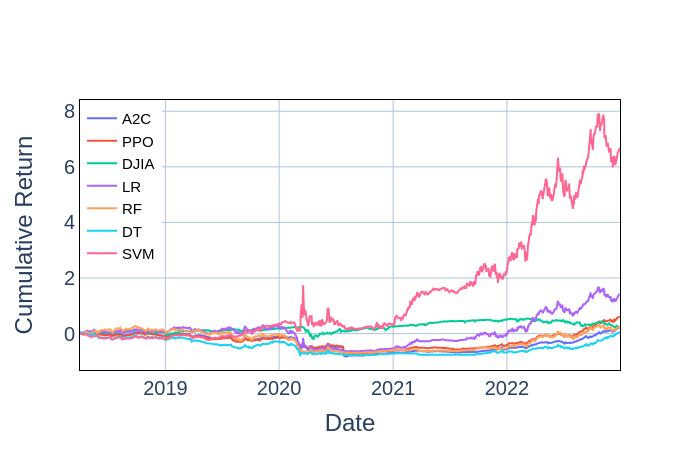

In [50]:

fig = go.Figure()
fig.add_trace(trace1_portfolio)
fig.add_trace(trace2_portfolio)

fig.add_trace(trace3_portfolio)

fig.add_trace(trace4_portfolio)
fig.add_trace(trace5_portfolio)
fig.add_trace(trace6_portfolio)
fig.add_trace(trace7_portfolio)

fig.update_layout(
    legend=dict(
        x=0,
        y=1,
        traceorder="normal",
        font=dict(
            family="sans-serif",
            size=15,
            color="black"
        ),
        bgcolor="White",
        bordercolor="white",
        borderwidth=2

    ),
)
fig.update_layout(title={
        #'text': "Cumulative Return using FinRL",
        'y':0.85,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig.update_layout(
    paper_bgcolor='rgba(1,1,0,0)',
    plot_bgcolor='rgba(1, 1, 0, 0)',
    xaxis_title="Date",
    yaxis = dict(titlefont = dict(size = 30), title = "Cumulative Return"),
    font=dict(
        size=40,
    ),
)
fig.update_layout(font_size = 20)
fig.update_traces(line=dict(width=2))

fig.update_xaxes(showline=True, linecolor='black',showgrid=True, gridwidth=1, gridcolor='LightSteelBlue',mirror=True)
fig.update_yaxes(showline=True,linecolor='black',showgrid=True, gridwidth=1, gridcolor='LightSteelBlue',mirror=True)
fig.update_yaxes(zeroline=True, zerolinewidth=1, zerolinecolor='LightSteelBlue')

fig.show("png")

#### We found that A2C and PPO succeeded in the portfoli management task and is better than all other algorithms/benchmark.

In [51]:
meta_score = {"Annual return":[], "Annual volatility":[], "Max drawdown":[], "Sharpe ratio":[], "Algorithm":[], "Calmar ratio":[]}
for name in ["LR", "A2C", "RF", "Reference Model", "PPO", "SVM", "DT", "DJI"]:
  if name == "DT":
    annualreturn = dt_stats["Annual return"]
    annualvol = dt_stats["Annual volatility"]
    sharpeRatio = dt_stats["Sharpe ratio"]
    maxdradown = dt_stats["Max drawdown"]
    calmarratio = dt_stats["Calmar ratio"]
  elif name == "LR":
    annualreturn = lr_stats["Annual return"]
    annualvol = lr_stats["Annual volatility"]
    sharpeRatio = lr_stats["Sharpe ratio"]
    maxdradown = lr_stats["Max drawdown"]
    calmarratio = lr_stats["Calmar ratio"]
  elif name == "SVM":
    annualreturn = svm_stats["Annual return"]
    annualvol = svm_stats["Annual volatility"]
    sharpeRatio = svm_stats["Sharpe ratio"]
    maxdradown = svm_stats["Max drawdown"]
    calmarratio = svm_stats["Calmar ratio"]
  elif name == "RF":
    annualreturn = rf_stats["Annual return"]
    annualvol = rf_stats["Annual volatility"]
    sharpeRatio = rf_stats["Sharpe ratio"]
    maxdradown = rf_stats["Max drawdown"]
    calmarratio = rf_stats["Calmar ratio"]
  elif name == "Reference Model":
    annualreturn = reference_stats["Annual return"]
    annualvol = reference_stats["Annual volatility"]
    sharpeRatio = reference_stats["Sharpe ratio"]
    maxdradown = reference_stats["Max drawdown"]
    calmarratio = reference_stats["Calmar ratio"]
  elif name == "PPO":
    annualreturn = perf_stats_all_ppo["Annual return"]
    annualvol = perf_stats_all_ppo["Annual volatility"]
    sharpeRatio = perf_stats_all_ppo["Sharpe ratio"]
    maxdradown = perf_stats_all_ppo["Max drawdown"]
    calmarratio = perf_stats_all_ppo["Calmar ratio"]
  elif name == "DJI":
    annualreturn = baseline_df_stats["Annual return"]
    annualvol = baseline_df_stats["Annual volatility"]
    sharpeRatio = baseline_df_stats["Sharpe ratio"]
    maxdradown = baseline_df_stats["Max drawdown"]
    calmarratio = baseline_df_stats["Calmar ratio"]
  else:
    annualreturn = perf_stats_all_a2c["Annual return"]
    annualvol = perf_stats_all_a2c["Annual volatility"]
    sharpeRatio = perf_stats_all_a2c["Sharpe ratio"]
    maxdradown = perf_stats_all_a2c["Max drawdown"]
    calmarratio = perf_stats_all_a2c["Calmar ratio"]
  meta_score["Algorithm"] += [name]
  meta_score["Annual return"] += [annualreturn]
  meta_score["Annual volatility"] += [annualvol]
  meta_score["Max drawdown"] += [maxdradown]
  meta_score["Sharpe ratio"] += [sharpeRatio]
  meta_score["Calmar ratio"] += [calmarratio]

meta_score = pd.DataFrame(meta_score).sort_values("Sharpe ratio")


In [52]:
postiveRatio = pd.DataFrame(performance_score.groupby("algo").apply(lambda x : np.mean(x['score'])))

postiveRatio = postiveRatio.reset_index()
postiveRatio.columns = ['algo', 'avg_correlation_coefficient']
postiveRatio['Sharpe Ratio'] = [0] * 6

# postiveRatio.plot.bar(x = 'algo', y = 'avg_correlation_coefficient')

postiveRatiom = pd.DataFrame(multi_performance_score.groupby("algo").apply(lambda x : np.mean(x['score'])))
postiveRatiom = postiveRatiom.reset_index()
postiveRatiom.columns = ['algo', 'avg_correlation_coefficient']
postiveRatiom['Sharpe Ratio'] = [0] * 6

# postiveRatiom.plot.bar(x = 'algo', y = 'avg_correlation_coefficient')


for algo in ['A2C', 'PPO', 'LR','DT', 'RF', 'SVM']:
  postiveRatio.loc[postiveRatio['algo'] == algo, 'Sharpe Ratio'] = meta_score.loc[meta_score['Algorithm'] == algo,'Sharpe ratio'].values[0]
  postiveRatiom.loc[postiveRatio['algo'] == algo, 'Sharpe Ratio'] = meta_score.loc[meta_score['Algorithm'] == algo,'Sharpe ratio'].values[0]

postiveRatio.sort_values("Sharpe Ratio", inplace= True)

postiveRatiom.sort_values("Sharpe Ratio", inplace= True)


<ipython-input-52-71d59f036790>:18: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.3975377016998768' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

<ipython-input-52-71d59f036790>:19: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.3975377016998768' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



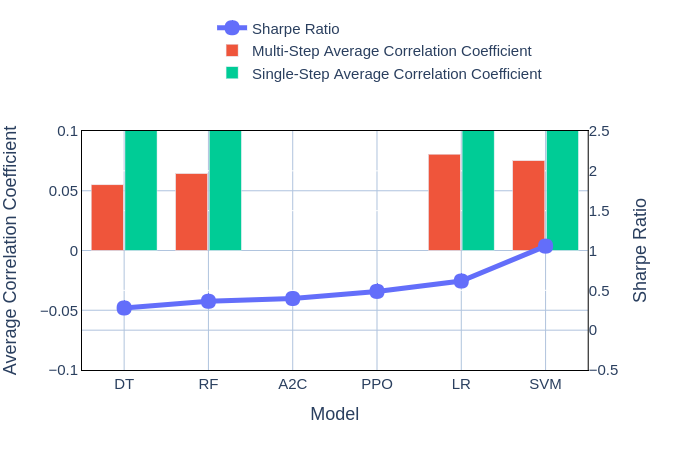

In [53]:

import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=postiveRatiom['algo'], y=postiveRatiom['Sharpe Ratio'], name="Sharpe Ratio", marker_size = 15, line_width=5),
    secondary_y=True,
)

fig.add_trace(
    go.Bar(x=postiveRatiom['algo'], y=postiveRatiom['avg_correlation_coefficient'], name="Multi-Step Average Correlation Coefficient          ", width
    =0.38),
    secondary_y=False,
)
fig.add_trace(
    go.Bar(x=postiveRatio['algo'], y=postiveRatio['avg_correlation_coefficient'], name="Single-Step Average Correlation Coefficient           ", width
    =0.38),
    secondary_y=False,
)

fig.update_layout(
    paper_bgcolor='rgba(1,1,0,0)',
    plot_bgcolor='rgba(1, 1, 0, 0)',
)
fig.update_layout(legend=dict(
    yanchor="top",
    y=1.5,
    xanchor="right",
    x=0.95
))
fig.update_layout(font_size = 15)

# Set x-axis title
fig.update_xaxes(title_text="Model")
fig.update_xaxes(showline=True, linecolor='black',showgrid=True,gridwidth=1, gridcolor='LightSteelBlue',mirror=True)
fig.update_yaxes(showline=True,linecolor='black',showgrid=True, secondary_y=False, gridwidth=1, gridcolor='LightSteelBlue',mirror=True)
fig.update_yaxes(zeroline=True, zerolinewidth=1, zerolinecolor='LightSteelBlue')
# Set y-axes titles
fig.update_yaxes(title_text="Average Correlation Coefficient", secondary_y=False, range = [-0.1,0.1])
fig.update_yaxes(title_text="Sharpe Ratio", secondary_y=True,range = [-0.5,2.5])

fig.show("png")

#### The correlation coefficient represents the level of prediction power.

We found that:
>*  The sharpe ratio is in accordance with both single-step and  multi-step average correlation coefficient.
>* DRL agents is better at multi-step prediction than ML algorithms while worse at single-step prediction

In [ ]:
# # First, install the necessary system dependencies for Orca
# !apt-get install -y xvfb xauth xfonts-base

# # Clone the Orca GitHub repository
# !git clone https://github.com/plotly/orca.git

# # Navigate to the Orca directory
# %cd orca

# # Install Orca from the GitHub repository using npm
# !npm install

# # Verify the Orca installation
# !npm ls -g --depth=0

# # Go back to your working directory if needed
# %cd ..

In [59]:

# import plotly.graph_objects as go
# from plotly.subplots import make_subplots


# fig = make_subplots(rows=2, cols=3)

# trace0 = go.Histogram(x=performance_score[performance_score['algo'] == 'A2C']['score'].values, nbinsx=25, name = 'A2C',histnorm='probability')
# trace1 = go.Histogram(x=performance_score[performance_score['algo'] == 'PPO']['score'].values, nbinsx=25, name = 'PPO',histnorm='probability')
# trace2 = go.Histogram(x=performance_score[performance_score['algo'] == 'DT']['score'].values, nbinsx=25, name = 'DT',histnorm='probability')
# trace3 = go.Histogram(x=performance_score[performance_score['algo'] == 'LR']['score'].values, nbinsx=25, name = 'LR',histnorm='probability')
# trace4 = go.Histogram(x=performance_score[performance_score['algo'] == 'SVM']['score'].values, nbinsx=25, name = 'SVM',histnorm='probability')
# trace5 = go.Histogram(x=performance_score[performance_score['algo'] == 'RF']['score'].values, nbinsx=25, name = 'RF',histnorm='probability')


# fig.append_trace(trace0, 1, 1)
# fig.append_trace(trace1, 1, 2)
# fig.append_trace(trace2, 1, 3)
# fig.append_trace(trace3, 2, 1)
# fig.append_trace(trace4, 2, 2)
# fig.append_trace(trace5, 2, 3)
# # Update xaxis properties
# fig.update_xaxes(title_text="Correlation coefficient", row=2, col=2)
# fig.update_yaxes(title_text="Frequency", row=1, col=1)
# fig.update_yaxes(title_text="Frequency", row=2, col=1)

# fig.update_layout(

#     paper_bgcolor='rgba(1,1,0,0)',
#     plot_bgcolor='rgba(1, 1, 0, 0)',
#      font=dict(

#         size=18,
#     ),

# )
# fig.update_layout(legend=dict(
#     yanchor="top",
#     y=0.99,
#     xanchor="left",
#     x=1
# ))

# fig.update_xaxes(showline=True,linecolor='black',showgrid=True, gridwidth=1, gridcolor='LightSteelBlue',mirror=True)
# fig.update_yaxes(showline=True,linecolor='black',showgrid=True, gridwidth=1, gridcolor='LightSteelBlue',mirror=True)
# fig.update_yaxes(zeroline=True, zerolinewidth=1, zerolinecolor='LightSteelBlue')

# fig.show("png")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


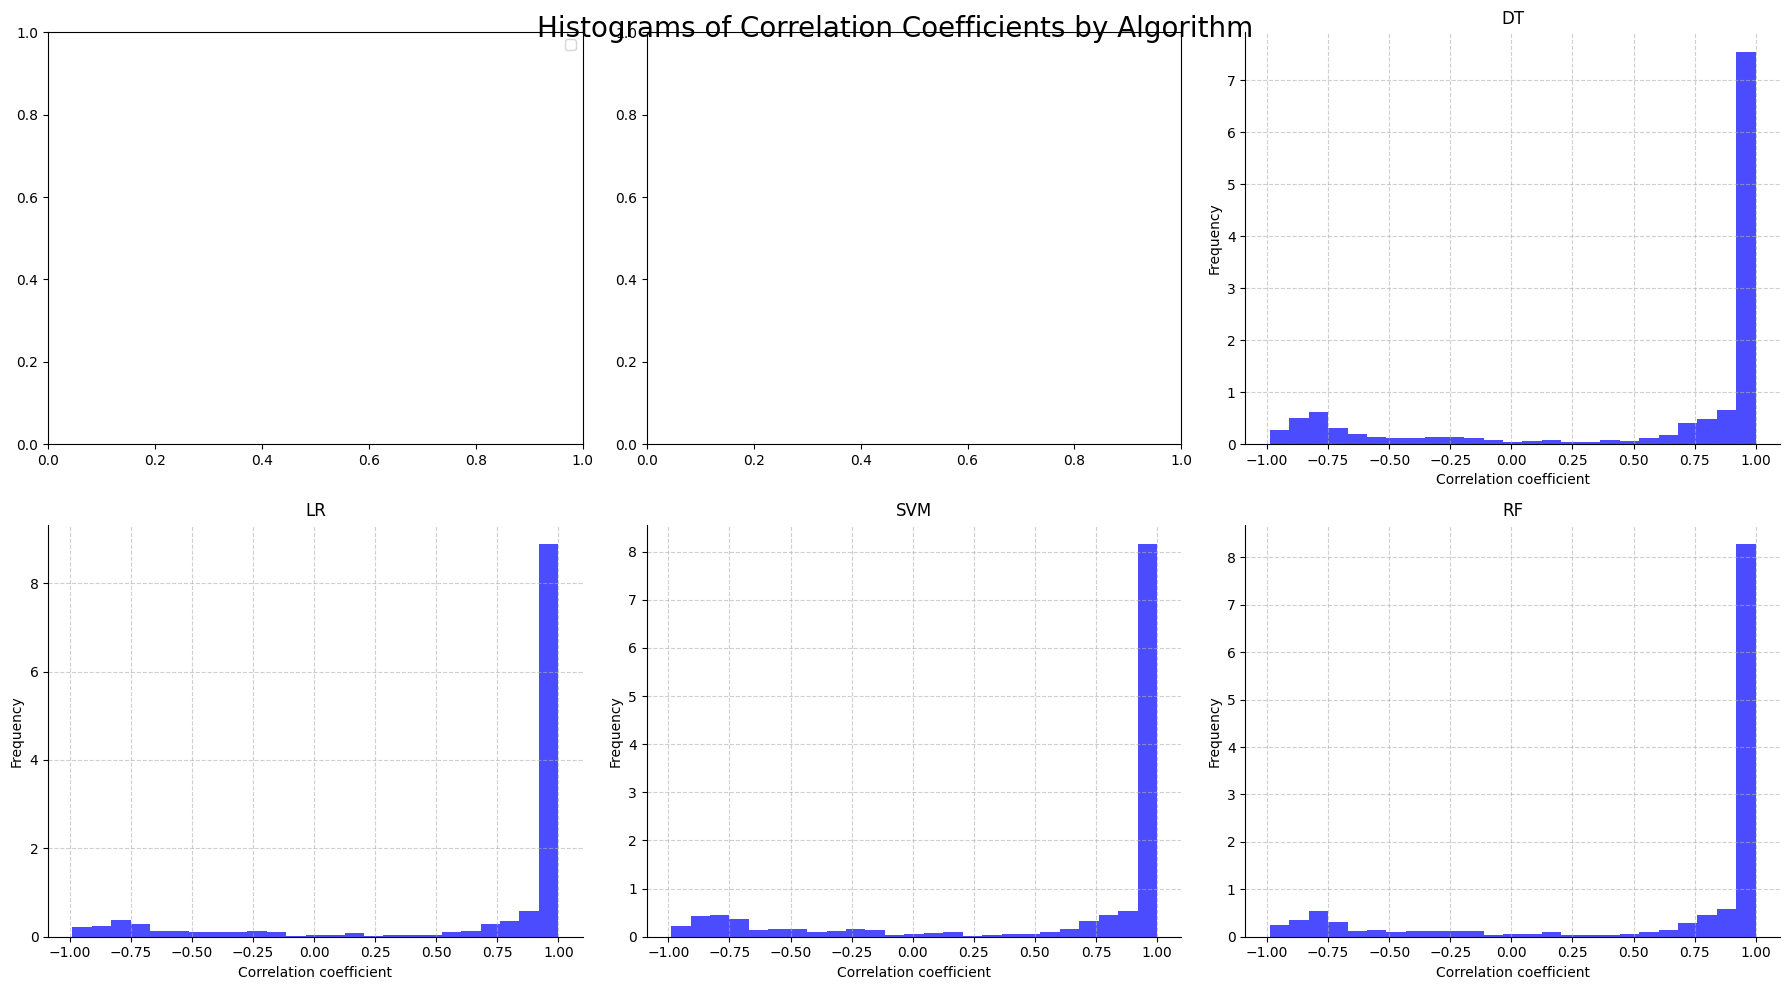

In [64]:
import matplotlib.pyplot as plt
import numpy as np

# Define the data for each algorithm
algo_names = ['A2C', 'PPO', 'DT', 'LR', 'SVM', 'RF']
algo_data = [performance_score[performance_score['algo'] == algo]['score'].values for algo in algo_names]

# Create subplots with 2 rows and 3 columns
fig, axs = plt.subplots(2, 3, figsize=(18, 10))

# Create histograms for each algorithm
for i, algo in enumerate(algo_names):
    row = i // 3
    col = i % 3
    ax = axs[row, col]

    # Remove NaN values from the data
    algo_data_cleaned = algo_data[i][~np.isnan(algo_data[i])]

    if len(algo_data_cleaned) > 0:
        ax.hist(algo_data_cleaned, bins=25, density=True, alpha=0.7, color='b', label=algo)
        ax.set_title(algo)
        ax.set_xlabel("Correlation coefficient")
        ax.set_ylabel("Frequency")
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

# Adjust spacing between subplots
plt.tight_layout()

# Add a legend to the first subplot
axs[0, 0].legend()

# Set overall plot title
fig.suptitle("Histograms of Correlation Coefficients by Algorithm", fontsize=20)

# Show the plot
plt.show()

#### Histogram of single-step correlation coefficient

In [61]:
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots


# fig = make_subplots(rows=2, cols=3)

# trace0 = go.Histogram(x=multi_performance_score[multi_performance_score['algo'] == 'A2C']['score'].values, nbinsx=25, name = 'A2C',histnorm='probability')
# trace1 = go.Histogram(x=multi_performance_score[multi_performance_score['algo'] == 'PPO']['score'].values, nbinsx=25, name = 'PPO',histnorm='probability')
# trace2 = go.Histogram(x=multi_performance_score[multi_performance_score['algo'] == 'DT']['score'].values, nbinsx=25, name = 'DT',histnorm='probability')
# trace3 = go.Histogram(x=multi_performance_score[multi_performance_score['algo'] == 'LR']['score'].values, nbinsx=25, name = 'LR',histnorm='probability')
# trace4 = go.Histogram(x=multi_performance_score[multi_performance_score['algo'] == 'SVM']['score'].values, nbinsx=25, name = 'SVM',histnorm='probability')
# trace5 = go.Histogram(x=multi_performance_score[multi_performance_score['algo'] == 'RF']['score'].values, nbinsx=25, name = 'RF',histnorm='probability')

# fig.update_layout(yaxis1 = dict(range=[0, 0.2]))
# fig.update_layout(yaxis2 = dict(range=[0, 0.2]))
# fig.update_layout(yaxis3 = dict(range=[0, 0.4]))
# fig.update_layout(yaxis4 = dict(range=[0, 0.4]))
# fig.update_layout(yaxis5 = dict(range=[0, 0.4]))
# fig.update_layout(yaxis6 = dict(range=[0, 0.4]))

# fig.append_trace(trace0, 1, 1)
# fig.append_trace(trace1, 1, 2)
# fig.append_trace(trace2, 1, 3)
# fig.append_trace(trace3, 2, 1)
# fig.append_trace(trace4, 2, 2)
# fig.append_trace(trace5, 2, 3)
# # Update xaxis properties
# fig.update_xaxes(title_text="Correlation coefficient", row=2, col=2)
# fig.update_yaxes(title_text="Frequency", row=1, col=1)
# fig.update_yaxes(title_text="Frequency", row=2, col=1)

# fig.update_layout(

#     paper_bgcolor='rgba(1,1,0,0)',
#     plot_bgcolor='rgba(1, 1, 0, 0)',
#      font=dict(

#         size=18,
#     ),

# )
# fig.update_layout(legend=dict(
#     yanchor="top",
#     y=0.99,
#     xanchor="left",
#     x=1
# ))

# fig.update_xaxes(showline=True,linecolor='black',showgrid=True, gridwidth=1, gridcolor='LightSteelBlue',mirror=True)
# fig.update_yaxes(showline=True,linecolor='black',showgrid=True, gridwidth=1, gridcolor='LightSteelBlue',mirror=True)
# fig.update_yaxes(zeroline=True, zerolinewidth=1, zerolinecolor='LightSteelBlue')

# fig.show("png")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


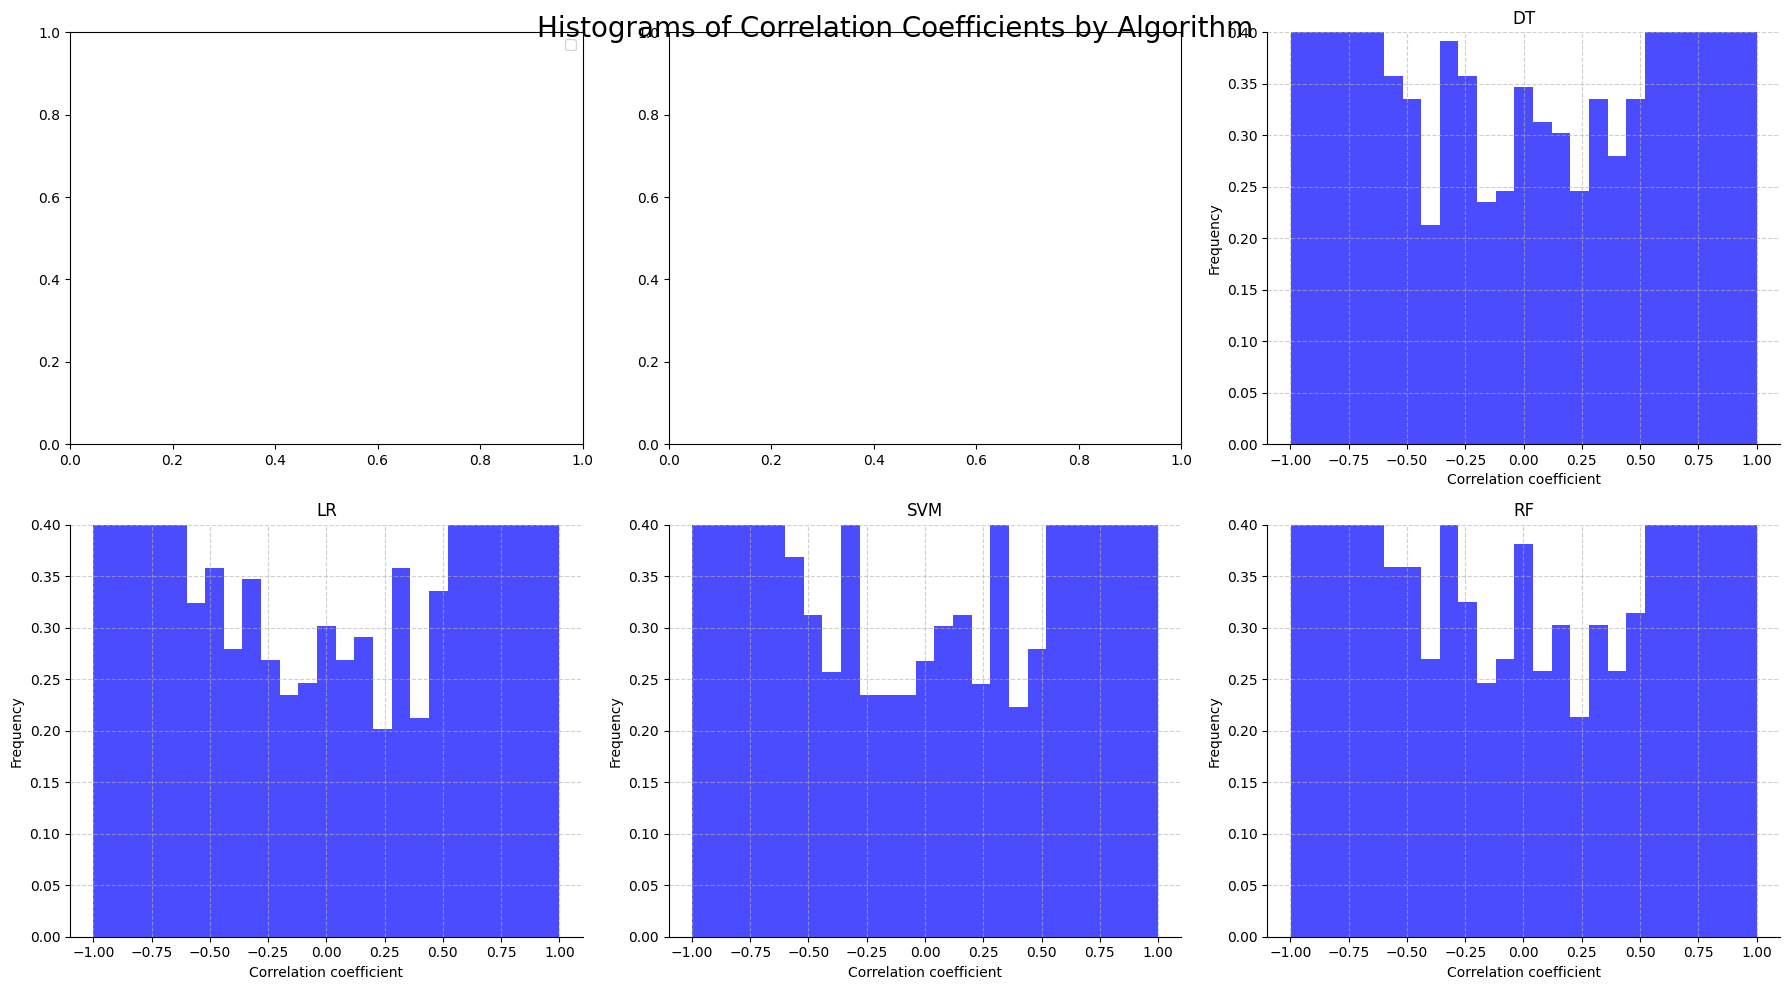

In [63]:
import matplotlib.pyplot as plt
import numpy as np

# Define the data for each algorithm
algo_names = ['A2C', 'PPO', 'DT', 'LR', 'SVM', 'RF']

# Create subplots with 2 rows and 3 columns
fig, axs = plt.subplots(2, 3, figsize=(18, 10))

# Create histograms for each algorithm
for i, algo in enumerate(algo_names):
    row = i // 3
    col = i % 3
    ax = axs[row, col]

    # Remove NaN values from the data
    algo_data_cleaned = algo_data[i][~np.isnan(algo_data[i])]

    if len(algo_data_cleaned) > 0:
        ax.hist(algo_data_cleaned, bins=25, density=True, alpha=0.7, color='b', label=algo)
        ax.set_title(algo)
        ax.set_xlabel("Correlation coefficient")
        ax.set_ylabel("Frequency")
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        # Apply custom y-axis ranges
        if i == 0:
            ax.set_ylim(0, 0.2)
        else:
            ax.set_ylim(0, 0.4)

# Adjust spacing between subplots
plt.tight_layout()

# Add a legend to the first subplot
axs[0, 0].legend()

# Set overall plot title
plt.suptitle("Histograms of Correlation Coefficients by Algorithm", fontsize=20)

# Show the plot
plt.show()

#### Histogram of multi-step correlation coefficient